# VectorEmbeddingService Test Results

This notebook tests the intent classification API routes against multiple prompts to evaluate performance.

## API Routes Tested
- `/api/intent/embedding` - Vector embedding-based classification
- `/api/intent/slm` - Small Language Model classification
- `/api/intent/hybrid` - Hybrid approach (vector + SLM)


## Setup

Load test prompts and import required libraries.


In [1]:
!pip install --upgrade pip
!pip install requests

In [2]:
import requests
import json
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from sklearn.metrics import confusion_matrix

    
# Load test prompts from data/testPrompts.json
# Each prompt has {intent, text} structure
prompts_path = Path('data') / 'testPrompts.json'

# If not found, try absolute path from current working directory
if not prompts_path.exists():
    import os
    project_root = Path(os.getcwd())
    prompts_path = project_root / 'data' / 'testPrompts.json'

with open(prompts_path, 'r', encoding='utf-8') as f:
    prompts_data = json.load(f)
    test_prompts = prompts_data['testPrompts']

print(f"Loaded {len(test_prompts)} test prompts from {prompts_path}")
print(f"Prompts structure: {{intent, text}}")

Loaded 270 test prompts from data/testPrompts.json
Prompts structure: {intent, text}


## Test Functions

Functions to test each API route.


In [3]:
def test_embedding_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/embedding') -> List[Dict[str, Any]]:
    """Test the embedding API route."""
    results = []
    
    for prompt_obj in prompts:
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')
        
        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=10
            )
            response.raise_for_status()
            
            data = response.json()
            actual_intent = data.get('intent', {}).get('intent', 'N/A')
            if actual_intent == 'toFallback':
                continue
            
            is_correct = None
            if expected_intent:
                is_correct = actual_intent == expected_intent
            
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'actualIntent': actual_intent,
                'isCorrect': is_correct,
                'score': data.get('intent', {}).get('score', 0),
                'candidates': data.get('candidates', []),
                'route': 'embedding'
            })
        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'embedding'
            })
        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'embedding'
            })
    
    return results

print("Embedding API test function defined")


Embedding API test function defined


In [4]:
def test_slm_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/slm') -> List[Dict[str, Any]]:
    """Test the SLM API route."""
    results = []
    
    for prompt_obj in prompts:
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')
        
        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=10
            )
            response.raise_for_status()
            
            data = response.json()
            classification = data.get('classification', {})
            actual_intent = classification.get('intent', 'N/A')
            is_correct = None
            if expected_intent:
                is_correct = actual_intent == expected_intent
            
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'actualIntent': actual_intent,
                'isCorrect': is_correct,
                'classification': classification,
                'route': 'slm'
            })
        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'slm'
            })
        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'slm'
            })
    
    return results

print("SLM API test function defined")


SLM API test function defined


In [5]:
def test_hybrid_api(prompts: List[Dict[str, Any]], api_url: str = 'http://localhost:3000/api/intent/hybrid') -> List[Dict[str, Any]]:
    """Test the hybrid API route."""
    results = []
    
    for prompt_obj in prompts:
        text = prompt_obj.get('text', '')
        expected_intent = prompt_obj.get('intent')
        
        try:
            response = requests.post(
                api_url,
                json={'message': text},
                headers={'Content-Type': 'application/json'},
                timeout=10
            )
            response.raise_for_status()
            
            data = response.json()
            vector_matches = data.get('vectorMatches', [])
            slm_result = data.get('slm', {})
            
            # Get intents from both approaches
            vector_intent = vector_matches[0].get('intent', 'N/A') if vector_matches else 'N/A'
            slm_intent = slm_result.get('intent', 'N/A')
            
            # Use SLM intent as primary (hybrid approach)
            actual_intent = slm_intent if slm_intent != 'N/A' else vector_intent
            is_correct = None
            if expected_intent:
                is_correct = actual_intent == expected_intent
            
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'actualIntent': actual_intent,
                'vectorIntent': vector_intent,
                'slmIntent': slm_intent,
                'isCorrect': is_correct,
                'vectorMatches': vector_matches,
                'slmResult': slm_result,
                'route': 'hybrid'
            })
        except requests.exceptions.RequestException as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': str(e),
                'route': 'hybrid'
            })
        except Exception as e:
            results.append({
                'text': text,
                'expectedIntent': expected_intent or 'N/A',
                'error': f'Unexpected error: {str(e)}',
                'route': 'hybrid'
            })
    
    return results

print("Hybrid API test function defined")


Hybrid API test function defined


## Analysis Functions

Functions to analyze and display test results.


In [6]:
def analyze_results(results: List[Dict[str, Any]], route_name: str = '') -> Dict[str, Any]:
    """Analyze and display test results with accuracy metrics."""
    route_label = f" ({route_name})" if route_name else ""
    
    success_count = 0
    error_count = 0
    correct_count = 0
    incorrect_count = 0
    intent_distribution = {}
    accuracy_by_intent = {}
    
    for idx, result in enumerate(results, 1):
        text = result.get('text', 'N/A')
        
        if 'error' in result:
            error_count += 1
        else:
            expected = result.get('expectedIntent', 'N/A')
            actual = result.get('actualIntent', 'N/A')
            is_correct = result.get('isCorrect')
            
            if expected and expected != 'N/A':
                if is_correct is True:
                    correct_count += 1
                elif is_correct is False:
                    incorrect_count += 1
            
            # Track intent distribution
            if actual != 'N/A':
                intent_distribution[actual] = intent_distribution.get(actual, 0) + 1
            
            # Track accuracy by expected intent
            if expected and expected != 'N/A' and is_correct is not None:
                if expected not in accuracy_by_intent:
                    accuracy_by_intent[expected] = {'correct': 0, 'total': 0}
                accuracy_by_intent[expected]['total'] += 1
                if is_correct:
                    accuracy_by_intent[expected]['correct'] += 1
            
            success_count += 1
    
    print('\n=== SUMMARY STATISTICS ===')
    print(f'Total Prompts: {len(results)}')
    print(f'Successful: {success_count}')
    print(f'Errors: {error_count}')
    
    if correct_count + incorrect_count > 0:
        accuracy = (correct_count / (correct_count + incorrect_count) * 100)
        print(f'\nAccuracy: {correct_count}/{correct_count + incorrect_count} ({accuracy:.2f}%)')
        print(f'  Correct: {correct_count}')
        print(f'  Incorrect: {incorrect_count}')
    
    print(f'\nIntent Distribution (Predicted):')
    for intent, count in sorted(intent_distribution.items(), key=lambda x: x[1], reverse=True):
        print(f'  {intent}: {count}')
    
    if accuracy_by_intent:
        print(f'\nAccuracy by Intent:')
        for intent, stats in sorted(accuracy_by_intent.items()):
            acc = (stats['correct'] / stats['total'] * 100) if stats['total'] > 0 else 0
            print(f'  {intent}: {stats["correct"]}/{stats["total"]} ({acc:.2f}%)')
    
    return {
        'total': len(results),
        'successful': success_count,
        'errors': error_count,
        'correct': correct_count,
        'incorrect': incorrect_count,
        'accuracy': (correct_count / (correct_count + incorrect_count) * 100) if (correct_count + incorrect_count) > 0 else None,
        'intent_distribution': intent_distribution,
        'accuracy_by_intent': accuracy_by_intent
    }

print("Results analysis function defined")


Results analysis function defined


## Run Tests

Execute tests against all API routes. Make sure your Next.js server is running: `npm run dev`


In [7]:
# Test Embedding API
print("Testing Embedding API...")
embedding_results = test_embedding_api(test_prompts)
embedding_summary = analyze_results(embedding_results, 'Embedding')

# Store results
embedding_test_data = {
    'results': embedding_results,
    'summary': embedding_summary,
    'timestamp': datetime.now().isoformat(),
    'route': 'embedding'
}


Testing Embedding API...

=== SUMMARY STATISTICS ===
Total Prompts: 247
Successful: 247
Errors: 0

Accuracy: 141/247 (57.09%)
  Correct: 141
  Incorrect: 106

Intent Distribution (Predicted):
  problem_solving_search: 42
  price_query: 40
  bulk_or_budget_search: 36
  comparison_search: 29
  navigation: 24
  attribute_based_search: 22
  direct_product_search: 18
  navigation_with_parameters: 18
  project_based_search: 18

Accuracy by Intent:
  attribute_based_search: 11/28 (39.29%)
  bulk_or_budget_search: 20/30 (66.67%)
  comparison_search: 17/29 (58.62%)
  direct_product_search: 8/24 (33.33%)
  navigation: 18/23 (78.26%)
  navigation_with_parameters: 14/24 (58.33%)
  price_query: 15/29 (51.72%)
  problem_solving_search: 24/30 (80.00%)
  project_based_search: 14/30 (46.67%)


In [8]:
# Test SLM API
print("Testing SLM API...")
slm_results = test_slm_api(test_prompts)
slm_summary = analyze_results(slm_results, 'SLM')

# Store results
slm_test_data = {
    'results': slm_results,
    'summary': slm_summary,
    'timestamp': datetime.now().isoformat(),
    'route': 'slm'
}


Testing SLM API...

=== SUMMARY STATISTICS ===
Total Prompts: 270
Successful: 270
Errors: 0

Accuracy: 0/270 (0.00%)
  Correct: 0
  Incorrect: 270

Intent Distribution (Predicted):
  other: 260
  billing: 9
  greeting: 1

Accuracy by Intent:
  attribute_based_search: 0/30 (0.00%)
  bulk_or_budget_search: 0/30 (0.00%)
  comparison_search: 0/30 (0.00%)
  direct_product_search: 0/30 (0.00%)
  navigation: 0/30 (0.00%)
  navigation_with_parameters: 0/30 (0.00%)
  price_query: 0/30 (0.00%)
  problem_solving_search: 0/30 (0.00%)
  project_based_search: 0/30 (0.00%)


In [9]:
# Test Hybrid API
print("Testing Hybrid API...")
hybrid_results = test_hybrid_api(test_prompts)
hybrid_summary = analyze_results(hybrid_results, 'Hybrid')

# Store results
hybrid_test_data = {
    'results': hybrid_results,
    'summary': hybrid_summary,
    'timestamp': datetime.now().isoformat(),
    'route': 'hybrid'
}


Testing Hybrid API...

=== SUMMARY STATISTICS ===
Total Prompts: 270
Successful: 270
Errors: 0

Accuracy: 0/270 (0.00%)
  Correct: 0
  Incorrect: 270

Intent Distribution (Predicted):
  other: 260
  billing: 9
  greeting: 1

Accuracy by Intent:
  attribute_based_search: 0/30 (0.00%)
  bulk_or_budget_search: 0/30 (0.00%)
  comparison_search: 0/30 (0.00%)
  direct_product_search: 0/30 (0.00%)
  navigation: 0/30 (0.00%)
  navigation_with_parameters: 0/30 (0.00%)
  price_query: 0/30 (0.00%)
  problem_solving_search: 0/30 (0.00%)
  project_based_search: 0/30 (0.00%)


## Compare Results

Compare performance across all three API routes.


In [10]:
# Compare all routes
print("\n=== ROUTE COMPARISON ===\n")

routes = [
    ('Embedding', embedding_summary),
    ('SLM', slm_summary)
]

print(f"{'Route':<15} {'Accuracy':<15} {'Correct':<10} {'Incorrect':<12} {'Errors':<10}")
print("-" * 65)

for route_name, summary in routes:
    accuracy = summary.get('accuracy')
    accuracy_str = f"{accuracy:.2f}%" if accuracy is not None else "N/A"
    correct = summary.get('correct', 0)
    incorrect = summary.get('incorrect', 0)
    errors = summary.get('errors', 0)
    
    print(f"{route_name:<15} {accuracy_str:<15} {correct:<10} {incorrect:<12} {errors:<10}")

# Find best route
best_route = max(routes, key=lambda x: x[1].get('accuracy', 0) if x[1].get('accuracy') is not None else 0)
print(f"\nBest performing route: {best_route[0]} ({best_route[1].get('accuracy', 0):.2f}% accuracy)")


=== ROUTE COMPARISON ===

Route           Accuracy        Correct    Incorrect    Errors    
-----------------------------------------------------------------
Embedding       57.09%          141        106          0         
SLM             0.00%           0          270          0         

Best performing route: Embedding (57.09% accuracy)


## Export Results

Export test results to JSON files for further analysis.


In [11]:
def export_results(results: List[Dict[str, Any]], summary: Dict[str, Any], filename: str):
    """Export test results to JSON file."""
    output = {
        'timestamp': datetime.now().isoformat(),
        'total_prompts': len(results),
        'results': results,
        'summary': summary
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(output, f, indent=2, ensure_ascii=False)
    
    print(f' Results exported to {filename}')
    return output

# Export all results
# Uncomment to export
# export_results(embedding_results, embedding_summary, 'embedding_test_results.json')
# export_results(slm_results, slm_summary, 'slm_test_results.json')
# export_results(hybrid_results, hybrid_summary, 'hybrid_test_results.json')

# Export combined comparison
# combined_output = {
#     'timestamp': datetime.now().isoformat(),
#     'embedding': embedding_test_data,
#     'slm': slm_test_data,
#     'hybrid': hybrid_test_data
# }
# with open('all_routes_test_results.json', 'w', encoding='utf-8') as f:
#     json.dump(combined_output, f, indent=2, ensure_ascii=False)
# print(' Combined results exported to all_routes_test_results.json')


## Detailed Analysis with Pandas

Display results in tabular format (optional, requires pandas).


In [12]:
   
# Create DataFrame for embedding results
df_embedding = pd.DataFrame([
    {
        'text': r.get('text', 'N/A'),
        'expected_intent': r.get('expectedIntent', 'N/A'),
        'actual_intent': r.get('actualIntent', 'N/A'),
        'is_correct': r.get('isCorrect'),
        'score': r.get('score', 0),
        'error': r.get('error', '')
    }
    for r in embedding_results
])

print("\n=== EMBEDDING RESULTS TABLE ===")
display(df_embedding[df_embedding["is_correct"] == False])





=== EMBEDDING RESULTS TABLE ===


,text,expected_intent,actual_intent,is_correct,score,error
8,porcelanato 60x60 beige,direct_product_search,price_query,False,0.652696,
9,malla electrosoldada 6mm,direct_product_search,attribute_based_search,False,1.000000,
10,cable eléctrico 10 AWG,direct_product_search,attribute_based_search,False,0.834714,
11,pintura esmalte negro,direct_product_search,bulk_or_budget_search,False,0.698580,
12,yeso drywall tipo RH,direct_product_search,price_query,False,0.731155,
...,...,...,...,...,...,...
233,ver productos color blanco,navigation_with_parameters,problem_solving_search,False,0.640707,
234,abrir facturas entre 1 y 15 de mayo,navigation_with_parameters,navigation,False,0.745175,
235,facturas mayores a 100 dólares,navigation_with_parameters,navigation,False,0.683272,
238,ver productos tamaño 60x60,navigation_with_parameters,price_query,False,0.635546,


In [13]:
# Set a nice style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')

In [14]:
# Create comparison DataFrame
comparison_data = []
for i, prompt_obj in enumerate(test_prompts):
    text = prompt_obj.get('text', '')
    expected = prompt_obj.get('intent', 'N/A')

    embedding_result = embedding_results[i] if i < len(embedding_results) else {}
    slm_result = slm_results[i] if i < len(slm_results) else {}

    comparison_data.append({
        'text': text[:50] + '...' if len(text) > 50 else text,
        'expected': expected,
        'embedding': embedding_result.get('actualIntent', 'N/A'),
        'slm': slm_result.get('actualIntent', 'N/A'),
        'embedding_correct': embedding_result.get('isCorrect'),
        'slm_correct': slm_result.get('isCorrect'),
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n=== ROUTE COMPARISON TABLE ===")
display(df_comparison)


=== ROUTE COMPARISON TABLE ===


,text,expected,embedding,slm,embedding_correct,slm_correct
0,cemento holcim 50kg,direct_product_search,direct_product_search,other,True,False
1,pintura blanca para interiores,direct_product_search,direct_product_search,other,True,False
2,tubería pvc 2 pulgadas,direct_product_search,direct_product_search,other,True,False
3,cemento holcim 50kg,direct_product_search,direct_product_search,other,True,False
4,tubería pvc 1 pulgada para agua potable,direct_product_search,direct_product_search,other,True,False
...,...,...,...,...,...,...
265,muéstrame las facturas entre 5 mayo y 18 junio...,navigation_with_parameters,N/A,other,None,False
266,quiero ver productos categoría 'herramientas' ...,navigation_with_parameters,N/A,other,None,False
267,open invoices from last year solo las pendient...,navigation_with_parameters,N/A,billing,None,False
268,cotizaciones entre enero-marzo y filtradas por...,navigation_with_parameters,N/A,other,None,False


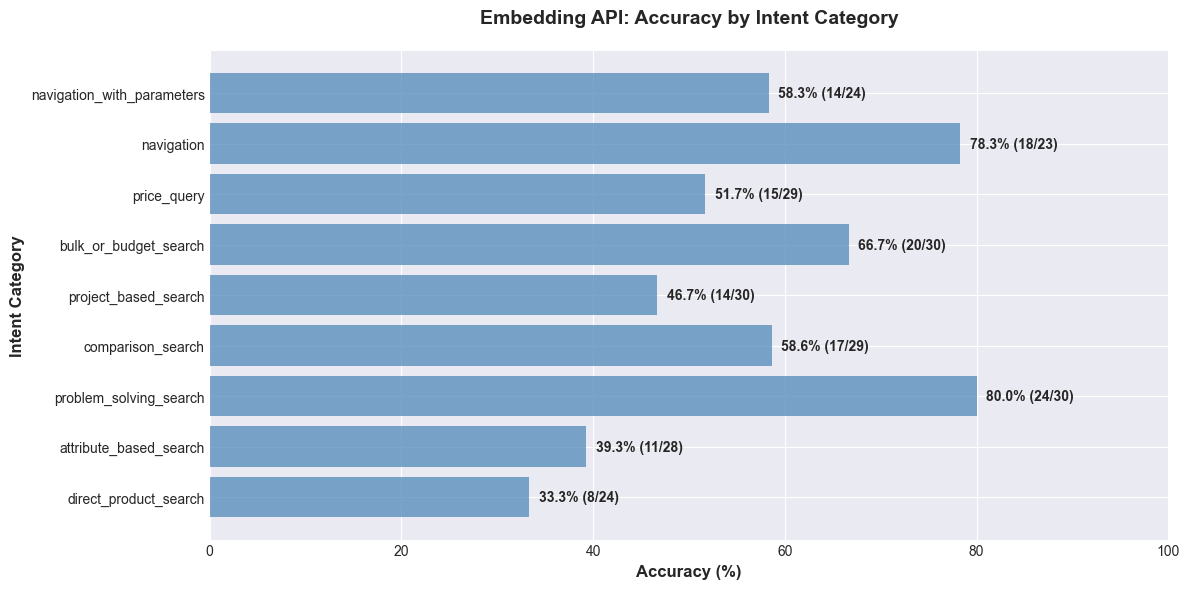

In [15]:
   
# ========== MATPLOTLIB VISUALIZATIONS ==========

# 1. Accuracy by Intent (Embedding)
if embedding_summary.get('accuracy_by_intent'):
    fig, ax = plt.subplots(figsize=(12, 6))
    intent_data = embedding_summary['accuracy_by_intent']
    intents = list(intent_data.keys())
    accuracies = [(intent_data[i]['correct'] / intent_data[i]['total'] * 100) 
                 if intent_data[i]['total'] > 0 else 0 for i in intents]
    totals = [intent_data[i]['total'] for i in intents]

    bars = ax.barh(intents, accuracies, color='steelblue', alpha=0.7)
    ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Intent Category', fontsize=12, fontweight='bold')
    ax.set_title('Embedding API: Accuracy by Intent Category', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, 100)

    # Add value labels on bars
    for i, (bar, acc, total) in enumerate(zip(bars, accuracies, totals)):
        width = bar.get_width()
        ax.text(width + 1, bar.get_y() + bar.get_height()/2, 
               f'{acc:.1f}% ({intent_data[intents[i]]["correct"]}/{total})',
               ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()


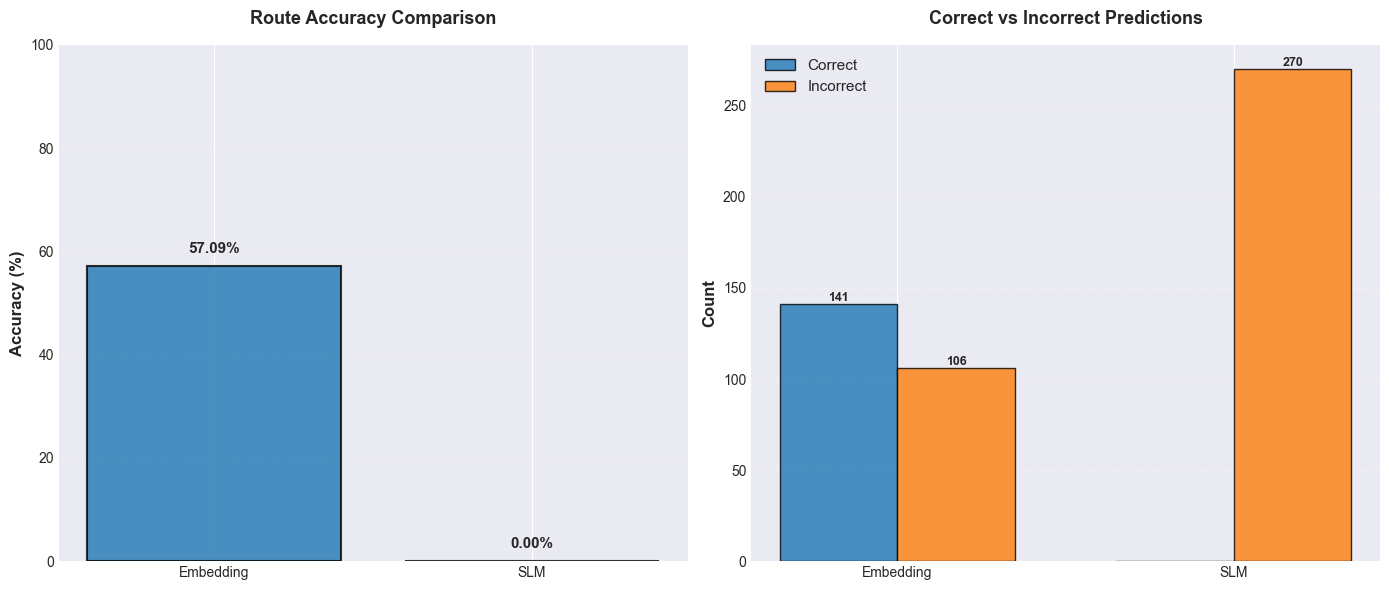

In [16]:

# 2. Route Comparison Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

routes = ['Embedding', 'SLM']
summaries = [embedding_summary, slm_summary]
accuracies = [s.get('accuracy', 0) if s.get('accuracy') is not None else 0 for s in summaries]
corrects = [s.get('correct', 0) for s in summaries]
incorrects = [s.get('incorrect', 0) for s in summaries]

# Accuracy comparison
bars1 = ax1.bar(routes, accuracies, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Route Accuracy Comparison', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Correct vs Incorrect comparison
x = np.arange(len(routes))
width = 0.35
bars2 = ax2.bar(x - width/2, corrects, width, label='Correct', alpha=0.8, edgecolor='black')
bars3 = ax2.bar(x + width/2, incorrects, width, label='Incorrect', alpha=0.8, edgecolor='black')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Correct vs Incorrect Predictions', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(routes)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

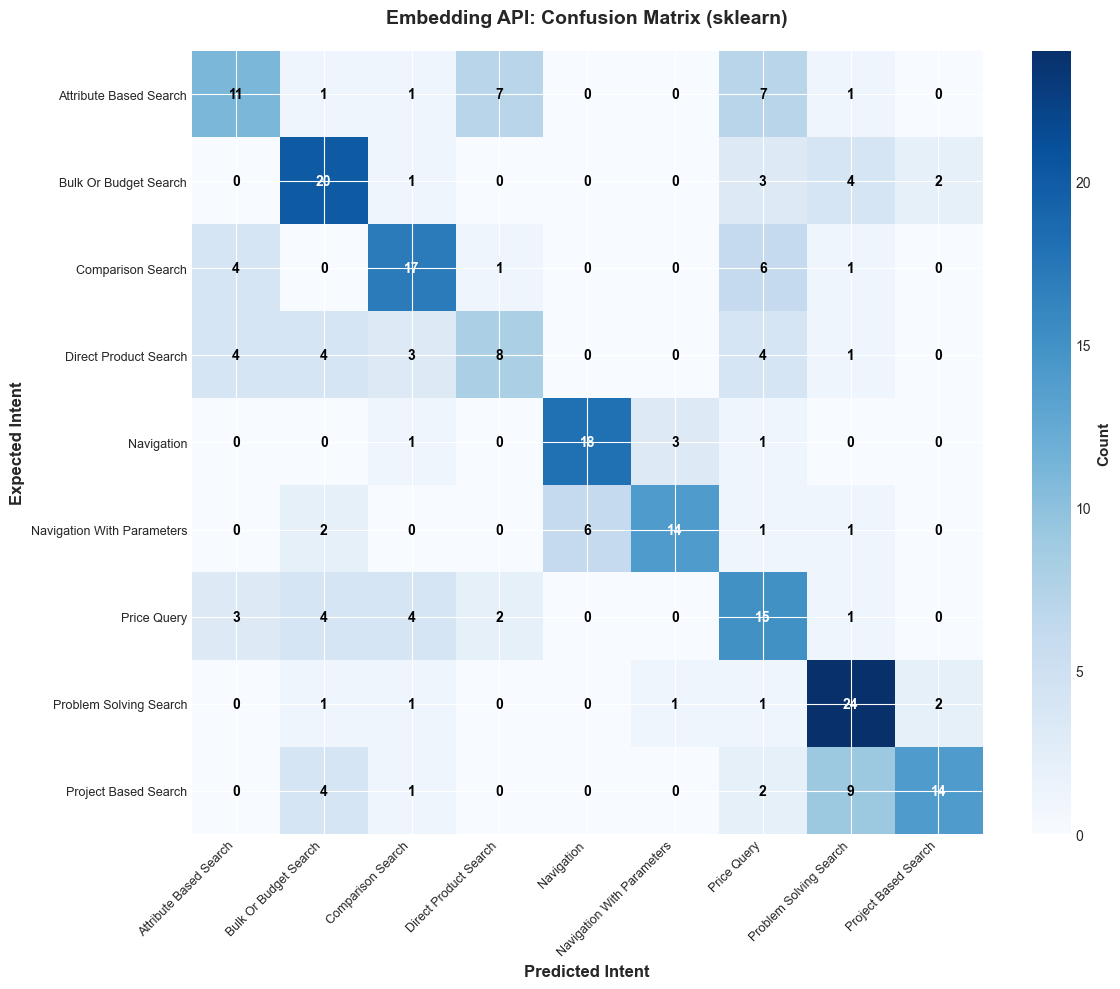

In [17]:
# 4. Intent Confusion Matrix (Embedding) using sklearn
if {'expected_intent', 'actual_intent'} <= set(df_embedding.columns):
    valid_rows = df_embedding[(df_embedding['expected_intent'] != 'N/A') & (df_embedding['actual_intent'] != 'N/A')]
    if not valid_rows.empty:
        expected_labels = valid_rows['expected_intent']
        predicted_labels = valid_rows['actual_intent']
        all_intents = sorted(set(expected_labels) | set(predicted_labels))

        cm = confusion_matrix(expected_labels, predicted_labels, labels=all_intents)

        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(cm, cmap='Blues', aspect='auto')

        ax.set_xticks(np.arange(len(all_intents)))
        ax.set_yticks(np.arange(len(all_intents)))
        ax.set_xticklabels([intent.replace('_', ' ').title() for intent in all_intents], rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels([intent.replace('_', ' ').title() for intent in all_intents], fontsize=9)

        thresh = cm.max() / 2.0 if cm.max() else 0
        for i in range(len(all_intents)):
            for j in range(len(all_intents)):
                value = int(cm[i, j])
                ax.text(j, i, value, ha='center', va='center',
                        color='white' if cm[i, j] > thresh else 'black', fontweight='bold')

        ax.set_xlabel('Predicted Intent', fontsize=12, fontweight='bold')
        ax.set_ylabel('Expected Intent', fontsize=12, fontweight='bold')
        ax.set_title('Embedding API: Confusion Matrix (sklearn)', fontsize=14, fontweight='bold', pad=20)

        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Count', fontsize=11, fontweight='bold')

        plt.tight_layout()
        plt.show()
    else:
        print('No valid rows to build a confusion matrix.')
else:
    print('Required columns not available for confusion matrix plot.')

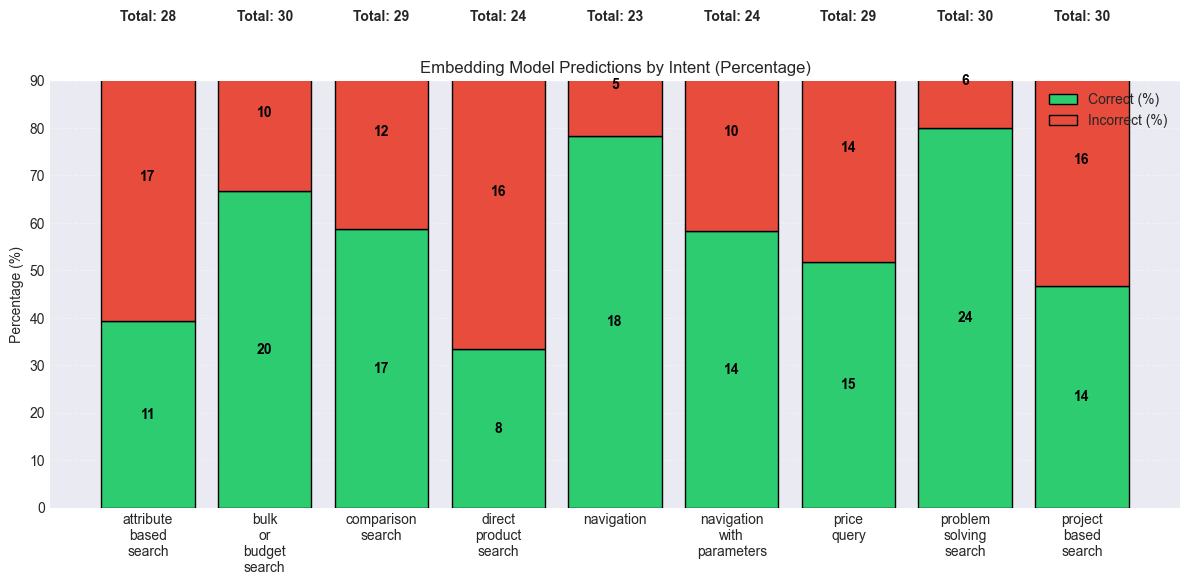

In [20]:
# Embedding model: per-intent stacked bars (percentages with counts)
intent_stats = embedding_summary.get('accuracy_by_intent', {})
if intent_stats:
    intents = sorted(intent_stats.keys())
    correct_counts = [intent_stats[intent]['correct'] for intent in intents]
    totals = [intent_stats[intent]['total'] for intent in intents]
    incorrect_counts = [total - correct for total, correct in zip(totals, correct_counts)]

    # Avoid division by zero
    correct_perc = [(correct / total * 100) if total else 0 for correct, total in zip(correct_counts, totals)]
    incorrect_perc = [100 - cp if total else 0 for cp, total in zip(correct_perc, totals)]

    x = np.arange(len(intents))
    fig, ax = plt.subplots(figsize=(12, 6))

    bars_correct = ax.bar(x, correct_perc, label='Correct (%)', color='#2ecc71', edgecolor='black')
    bars_incorrect = ax.bar(x, incorrect_perc, bottom=correct_perc, label='Incorrect (%)', color='#e74c3c', edgecolor='black')

    ax.set_xticks(x)
    ax.set_xticklabels([intent.replace('_', '\n') for intent in intents], rotation=0)
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 95)
    ax.set_title('Embedding Model Predictions by Intent (Percentage)')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    # annotate counts inside each bar segment
    for idx, bar in enumerate(bars_correct):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    height / 2,
                    f"{correct_counts[idx]}",
                    ha='center', va='center', color='black', fontweight='bold')

    for idx, bar in enumerate(bars_incorrect):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{incorrect_counts[idx]}",
                    ha='center', va='center', color='black', fontweight='bold')

    # totals above bars
    for idx, total in enumerate(totals):
        ax.text(x[idx], 102, f"Total: {total}", ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print('No intent statistics available to plot.')

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    display(df_embedding[df_embedding["is_correct"]==False])

,text,expected_intent,actual_intent,is_correct,score,error
8,porcelanato 60x60 beige,direct_product_search,price_query,False,0.652696,
9,malla electrosoldada 6mm,direct_product_search,attribute_based_search,False,1.000000,
10,cable eléctrico 10 AWG,direct_product_search,attribute_based_search,False,0.834714,
11,pintura esmalte negro,direct_product_search,bulk_or_budget_search,False,0.698580,
12,yeso drywall tipo RH,direct_product_search,price_query,False,0.731155,
13,pintura anticorrosiva gris,direct_product_search,bulk_or_budget_search,False,0.756994,
14,lámina de acero calibre 26,direct_product_search,price_query,False,0.639643,
15,ventana aluminio serie 20,direct_product_search,attribute_based_search,False,0.825144,
16,codo pvc 90 grados 1 pulgada,direct_product_search,price_query,False,0.764908,
17,grifería lavamanos cromada,direct_product_search,bulk_or_budget_search,False,0.601117,
